# Performing needed imports and boilder plate code.

In [76]:
import random
import torch
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import seaborn as sns

# set this variable to a number to be used as the random seed
# or to None if you don't want to set a random seed
seed = 1234

if seed is not None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Copied over data cleaning steps from our data cleaning notebook.

In [77]:
education_data = pd.read_csv('students_clean.csv')


education_data.drop('Parent_Education_Level', axis=1, inplace=True) 

education_data['Gender'] = education_data['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)
education_data['Internet_Access_at_Home'] = education_data['Internet_Access_at_Home'].replace({'Yes': 1, 'No': 0}).astype(int)
education_data['Extracurricular_Activities'] = education_data['Extracurricular_Activities'].replace({'Yes': 1, 'No': 0}).astype(int)


# Low = 1, Medium = 2, High = 3
mapper = {'low': 1, 'medium': 2, 'high': 3}

education_data['Family_Income_Level'] = (
    education_data['Family_Income_Level']
      .astype(str)                  # works even if the value is already 1/2/3 or NaN
      .str.strip().str.lower()
      .map(mapper)                  # returns NaN where no mapping found
      .fillna(education_data['Family_Income_Level'])  # keepin the original numeric/blank entries
      .astype('Int64')              #  nullable integer dtype
)

labels = open('departments.txt').read().splitlines()
department_mapping = {name: index for index, name in enumerate(labels)}
department_indices = education_data['Department'].map(department_mapping)
education_data.insert(3, 'department index', department_indices)
education_data = education_data.drop(columns='Department')

mapper = {'A': 1, 'B': 1, 'C': 1, 'D':0,'F':0}

education_data['Grade'] = (
    education_data['Grade']
      .astype(str)              # convert everything to string
      .str.strip().str.upper()  # remove spaces and standardize to uppercase
      .map(mapper)              # map letters to numbers
)

education_data.head()

/tmp/ipykernel_922700/1133007861.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education_data['Gender'] = education_data['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)
/tmp/ipykernel_922700/1133007861.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education_data['Internet_Access_at_Home'] = education_data['Internet_Access_at_Home'].replace({'Yes': 1, 'No': 0}).astype(int)
/tmp/ipykernel_922700/1133007861.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version

,Gender,Age,department index,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,0,22,0,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,0,10.3,1,0,2,1,5.9
1,1,18,1,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,1,27.1,0,0,1,4,4.3
2,1,24,2,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,0,12.4,1,0,1,9,6.1
3,0,24,2,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,0,25.5,0,1,1,8,4.9
4,0,23,3,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,1,13.3,1,0,2,6,4.5


# Now defining our data loader and perceptron

In [96]:
def get_features(data, column_name, exclude_cols, n):

    data = data.drop(columns=exclude_cols)
    
    corr_df = data.corr(method='pearson')[[column_name]]
    corr_df = corr_df.drop(index=[column_name])
    corr_df['Grade_Corr_Abs'] = corr_df[column_name].apply(lambda x: np.abs(x))
    corr_df = corr_df.sort_values(by='Grade_Corr_Abs',ascending=False)
    corr_df = corr_df[corr_df['Grade_Corr_Abs'] >= 0.1]
    top_features = corr_df.head(n).index.tolist()
    return top_features

In [97]:
get_features(education_data, 'Grade', ['Total_Score'], 10)

['Final_Score',
 'Projects_Score',
 'Assignments_Avg',
 'Midterm_Score',
 'Quizzes_Avg',
 'Participation_Score']

In [80]:
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        print(feature_cols)
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        x = torch.tensor(row[self.feature_cols].to_numpy(dtype=np.float32), dtype=torch.float32)
        y = torch.tensor(row[self.target_col], dtype=torch.long)  # long for classification
        return x, y

In [88]:
def train_perceptron(train_dl, n_features, pos_class):
    # First initialize the model.
    w = np.zeros(n_features)
    b = 0
    n_errors = 0
    weight_steps = []
    total_pos_in_train = 0

    # Adding this in for debug purposes to track the changes to the weight vectors on each
    # round.
    
    # Average perceptron features
    totalW = np.zeros(n_features)
    totalB = 0
    updates = 0
    tot_neg = 0
    
    
    # Now loop through each batch.
    for batch_idx, (x, y) in tqdm(enumerate(train_dl), total=len(train_dl),):
        
        x_curr_np = x.numpy()
        y_curr_np = y.numpy()

        tot_neg+= np.sum(y_curr_np==0)

        total_pos_in_train += (y_curr_np == 1).sum(axis=0)
        

        # Now perform the training/classification loop.
        scores = x_curr_np @ w + b
       
        
        y_pred = (scores > 0).astype(int)


        # Now we vectorize the update to make this more efficient.
        pred_error = y_curr_np - y_pred
        n_errors += np.sum(np.abs(pred_error) != 0) # If the pred error is zero then it is correct.

        # First append the previous weights to weight steps which will be used for debuging puprposes.
        weight_steps.append((pred_error[:,None]*x_curr_np).sum(axis=0).copy())

        totalW += w
        totalB += b
        updates += 1

        # For the purposes of the average perceptron we must first store the old w values.
        
        new_update = (pred_error[:,None]*x_curr_np).sum(axis=0)
        w += new_update
        b += pred_error.sum()

        # Now print out the weights and bias updates every update if we are in debug mode.
        

    w = totalW/updates
    b = totalB/updates
    # Now once we are done training the result is the weights and biases.
    print(f"The total negatives seen in training were: {tot_neg}")
    return (w,b,n_errors,weight_steps.copy(),total_pos_in_train) # I am just copying to avoid weird cases due to mutability of list.

# Create the training and testing partitions.

In [85]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(education_data, train_size=0.9,random_state=seed)
train_df,dev_df = train_test_split(train_df, train_size=0.8,random_state=seed)

train_df.reset_index(inplace=True,drop=True)
dev_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)


print(f'train rows: {len(train_df.index):,}')
print(f'dev rows: {len(dev_df.index):,}')
print(f'test rows: {len(test_df.index):,}')

train rows: 3,600
dev rows: 900
test rows: 500


In [86]:
# Check pass/fail distribution in train and dev datasets
print("="*70)
print("Pass/Fail Distribution in Datasets")
print("="*70)

# Train set distribution
train_pass = (train_df['Grade'] == 1).sum()
train_fail = (train_df['Grade'] == 0).sum()
train_total = len(train_df)

print(f"\nTrain Set:")
print(f"  Pass (1): {train_pass} ({train_pass/train_total*100:.2f}%)")
print(f"  Fail (0): {train_fail} ({train_fail/train_total*100:.2f}%)")
print(f"  Total: {train_total}")

# Dev set distribution
dev_pass = (dev_df['Grade'] == 1).sum()
dev_fail = (dev_df['Grade'] == 0).sum()
dev_total = len(dev_df)

print(f"\nDev Set:")
print(f"  Pass (1): {dev_pass} ({dev_pass/dev_total*100:.2f}%)")
print(f"  Fail (0): {dev_fail} ({dev_fail/dev_total*100:.2f}%)")
print(f"  Total: {dev_total}")

# Test set distribution
test_pass = (test_df['Grade'] == 1).sum()
test_fail = (test_df['Grade'] == 0).sum()
test_total = len(test_df)

print(f"\nTest Set:")
print(f"  Pass (1): {test_pass} ({test_pass/test_total*100:.2f}%)")
print(f"  Fail (0): {test_fail} ({test_fail/test_total*100:.2f}%)")
print(f"  Total: {test_total}")


Pass/Fail Distribution in Datasets

Train Set:
  Pass (1): 2105 (58.47%)
  Fail (0): 1495 (41.53%)
  Total: 3600

Dev Set:
  Pass (1): 555 (61.67%)
  Fail (0): 345 (38.33%)
  Total: 900

Test Set:
  Pass (1): 301 (60.20%)
  Fail (0): 199 (39.80%)
  Total: 500


# Before Midterm

['Total_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score']


  0%|          | 0/57 [00:00<?, ?it/s]

The total negatives seen in training were: 1495
-------------------Averaged Perceptron (10 perceptrons)------------------------------

Averaged weight vector shape: [2172.30159385 -262.36523237 -626.07488987 1155.45787181]
Averaged bias value: -38.4211

The number of correct preds was 555 for acc of 61.66666666666667%
The number of pos preds was 900 and neg num was 0

Detailed Evaluation Metrics:
Accuracy: 61.67%
Precision: 0.6167
Recall: 1.0000
F1-Score: 0.7629

Predictions breakdown:
  Predicted Fail (0): 0
  Predicted Pass (1): 900
  Actual Fail (0): 345
  Actual Pass (1): 555


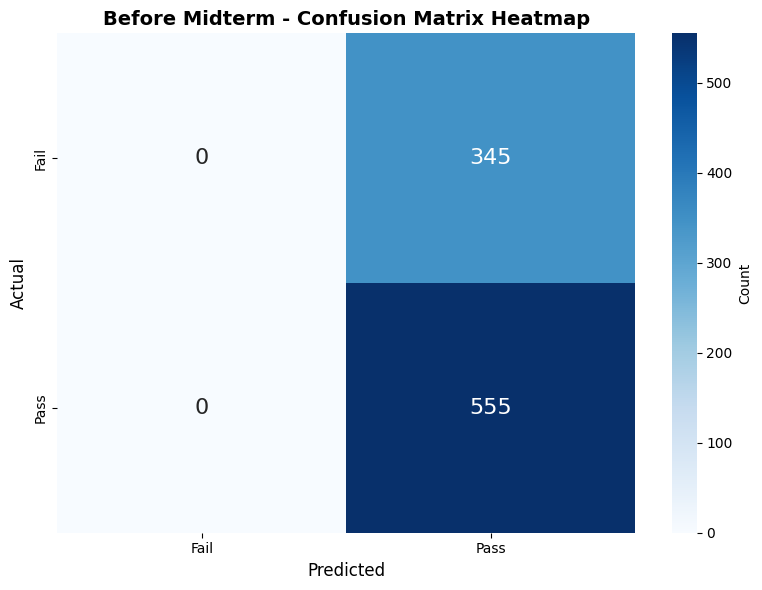

In [99]:
# Averaged Perceptron: Train 10 perceptrons and average their weights
n_perceptrons = 10
weight_vecs = []
bias_vecs = []
features_lst = get_features(education_data, 'Grade', ['Midterm_Score','Final_Score','Projects_Score'], 10)

num_feat = len(features_lst)
batch_size=64
shuffle = True


train_ds = MyDataset(train_df, features_lst, 'Grade')
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
w_avg, b_avg, error_avg, weight_hist_avg, tot_train_pos_avg = train_perceptron(train_dl, num_feat, pos_class=1)


print(f"-------------------Averaged Perceptron (10 perceptrons)------------------------------\n")
print(f"Averaged weight vector shape: {w_avg}")
print(f"Averaged bias value: {b_avg:.4f}\n")

# Test on dev.
X_dev_a = dev_df[features_lst].to_numpy()
dev_y_true = dev_df['Grade'].to_numpy()
dev_y_pred = ((X_dev_a @ w_avg + b_avg) > 0).astype(int)
n_correct_dev = (dev_y_true==dev_y_pred).sum(axis=0)

print(f"The number of correct preds was {n_correct_dev} for acc of {(n_correct_dev/dev_y_true.shape[0])*100}%")
print(f"The number of pos preds was {(dev_y_pred==1).sum(axis=0)} and neg num was {(dev_y_pred==0).sum(axis=0)}")

# Additional detailed metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(dev_y_true, dev_y_pred)
precision = precision_score(dev_y_true, dev_y_pred, zero_division=0)
recall = recall_score(dev_y_true, dev_y_pred, zero_division=0)
f1 = f1_score(dev_y_true, dev_y_pred, zero_division=0)
cm = confusion_matrix(dev_y_true, dev_y_pred)

print(f"\n{'='*70}")
print("Detailed Evaluation Metrics:")
print(f"{'='*70}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"\nPredictions breakdown:")
print(f"  Predicted Fail (0): {(dev_y_pred==0).sum()}")
print(f"  Predicted Pass (1): {(dev_y_pred==1).sum()}")
print(f"  Actual Fail (0): {(dev_y_true==0).sum()}")
print(f"  Actual Pass (1): {(dev_y_true==1).sum()}")

# Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'],
            annot_kws={'size': 16}, cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Before Midterm - Confusion Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# After Midterm and before Final

['Total_Score', 'Assignments_Avg', 'Midterm_Score', 'Quizzes_Avg', 'Participation_Score']


  0%|          | 0/57 [00:00<?, ?it/s]

The total negatives seen in training were: 1495
-------------------Averaged Perceptron (10 perceptrons)------------------------------

Averaged weight vector shape: [1844.6772904   -80.77996532  346.29777259 -617.30225687 1478.53851775]
Averaged bias value: -44.8421

The number of correct preds was 555 for acc of 61.66666666666667%
The number of pos preds was 900 and neg num was 0

Detailed Evaluation Metrics:
Accuracy: 61.67%
Precision: 0.6167
Recall: 1.0000
F1-Score: 0.7629

Predictions breakdown:
  Predicted Fail (0): 0
  Predicted Pass (1): 900
  Actual Fail (0): 345
  Actual Pass (1): 555


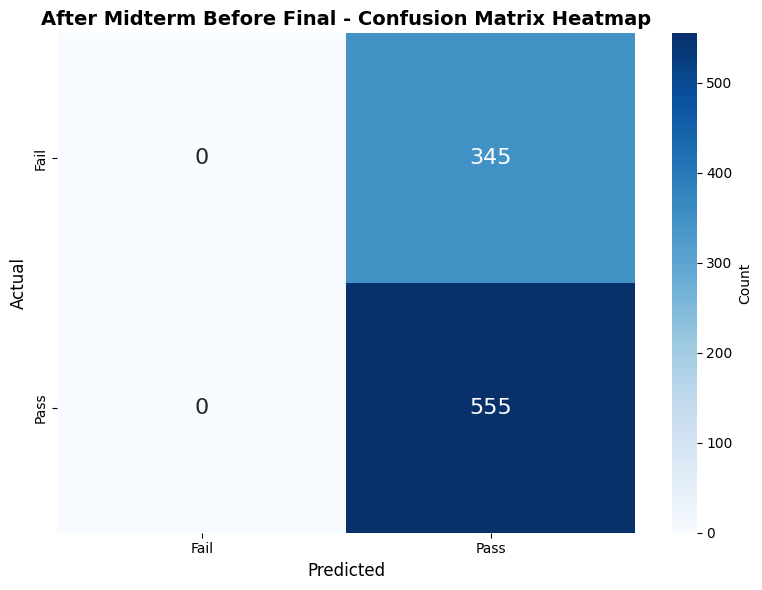

In [103]:
# Averaged Perceptron: Train 10 perceptrons and average their weights
n_perceptrons = 10
weight_vecs = []
bias_vecs = []
features_lst = get_features(education_data, 'Grade', ['Final_Score','Projects_Score'], 10)
num_feat = len(features_lst)
batch_size=64
shuffle = True

train_ds = MyDataset(train_df, features_lst, 'Grade')
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
w_avg, b_avg, error_avg, weight_hist_avg, tot_train_pos_avg = train_perceptron(train_dl, num_feat, pos_class=1)

print(f"-------------------Averaged Perceptron (10 perceptrons)------------------------------\n")
print(f"Averaged weight vector shape: {w_avg}")
print(f"Averaged bias value: {b_avg:.4f}\n")

# Test on dev.
X_dev_a = dev_df[features_lst].to_numpy()
dev_y_true = dev_df['Grade'].to_numpy()
dev_y_pred = ((X_dev_a @ w_avg + b_avg) > 0).astype(int)
n_correct_dev = (dev_y_true==dev_y_pred).sum(axis=0)

print(f"The number of correct preds was {n_correct_dev} for acc of {(n_correct_dev/dev_y_true.shape[0])*100}%")
print(f"The number of pos preds was {(dev_y_pred==1).sum(axis=0)} and neg num was {(dev_y_pred==0).sum(axis=0)}")

# Additional detailed metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(dev_y_true, dev_y_pred)
precision = precision_score(dev_y_true, dev_y_pred, zero_division=0)
recall = recall_score(dev_y_true, dev_y_pred, zero_division=0)
f1 = f1_score(dev_y_true, dev_y_pred, zero_division=0)
cm = confusion_matrix(dev_y_true, dev_y_pred)

print(f"\n{'='*70}")
print("Detailed Evaluation Metrics:")
print(f"{'='*70}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


print(f"\nPredictions breakdown:")
print(f"  Predicted Fail (0): {(dev_y_pred==0).sum()}")
print(f"  Predicted Pass (1): {(dev_y_pred==1).sum()}")
print(f"  Actual Fail (0): {(dev_y_true==0).sum()}")
print(f"  Actual Pass (1): {(dev_y_true==1).sum()}")

# Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'],
            annot_kws={'size': 16}, cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('After Midterm Before Final - Confusion Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# After Final

['Total_Score', 'Final_Score', 'Projects_Score', 'Assignments_Avg', 'Midterm_Score', 'Quizzes_Avg', 'Participation_Score']


  0%|          | 0/57 [00:00<?, ?it/s]

The total negatives seen in training were: 1495
-------------------Averaged Perceptron (10 perceptrons)------------------------------

Averaged weight vector shape: [ 1031.52933636  2953.80158421  1848.91090815  -429.02219016
  -264.41105645 -2025.68849637   899.78941993]
Averaged bias value: -57.7368

The number of correct preds was 555 for acc of 61.66666666666667%
The number of pos preds was 900 and neg num was 0

Detailed Evaluation Metrics:
Accuracy: 61.67%
Precision: 0.6167
Recall: 1.0000
F1-Score: 0.7629

Confusion Matrix:
                Predicted
              Fail    Pass
Actual Fail      0    345
       Pass      0    555


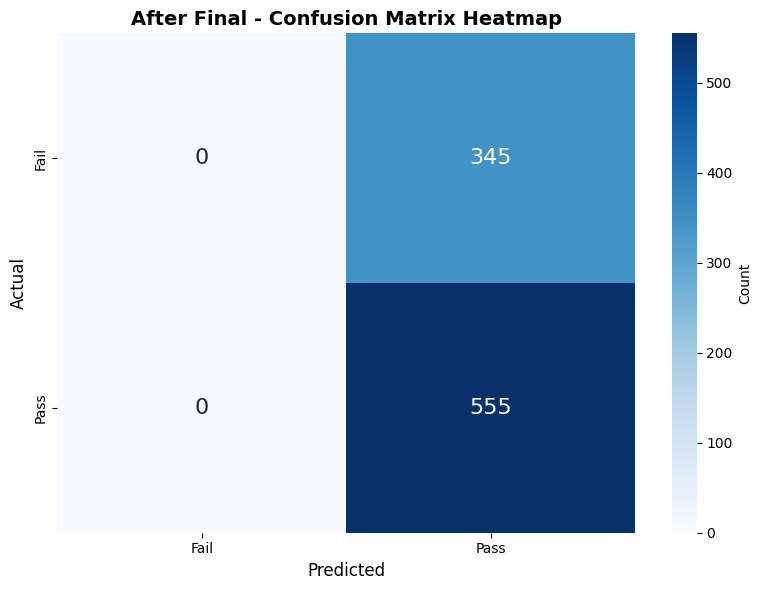

In [101]:
# Averaged Perceptron: Train 10 perceptrons and average their weights
n_perceptrons = 10
weight_vecs = []
bias_vecs = []
features_lst = get_features(education_data, 'Grade', [], 10)
num_feat = len(features_lst)
batch_size=64
shuffle = True

train_ds = MyDataset(train_df, features_lst, 'Grade')
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
w_avg, b_avg, error_avg, weight_hist_avg, tot_train_pos_avg = train_perceptron(train_dl, num_feat, pos_class=1)


print(f"-------------------Averaged Perceptron (10 perceptrons)------------------------------\n")
print(f"Averaged weight vector shape: {w_avg}")
print(f"Averaged bias value: {b_avg:.4f}\n")

# Test on dev.
X_dev_a = dev_df[features_lst].to_numpy()
dev_y_true = dev_df['Grade'].to_numpy()
dev_y_pred = ((X_dev_a @ w_avg + b_avg) > 0).astype(int)
n_correct_dev = (dev_y_true==dev_y_pred).sum(axis=0)

print(f"The number of correct preds was {n_correct_dev} for acc of {(n_correct_dev/dev_y_true.shape[0])*100}%")
print(f"The number of pos preds was {(dev_y_pred==1).sum(axis=0)} and neg num was {(dev_y_pred==0).sum(axis=0)}")

# Additional detailed metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(dev_y_true, dev_y_pred)
precision = precision_score(dev_y_true, dev_y_pred, zero_division=0)
recall = recall_score(dev_y_true, dev_y_pred, zero_division=0)
f1 = f1_score(dev_y_true, dev_y_pred, zero_division=0)
cm = confusion_matrix(dev_y_true, dev_y_pred)

print(f"\n{'='*70}")
print("Detailed Evaluation Metrics:")
print(f"{'='*70}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Fail    Pass")
print(f"Actual Fail   {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       Pass   {cm[1,0]:4d}   {cm[1,1]:4d}")

# Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'],
            annot_kws={'size': 16}, cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('After Final - Confusion Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [93]:
# Get indices where prediction = 1 but true = 0  (False Positives)
idx_pred_pass_actual_fail = np.where((dev_y_pred == 1) & (dev_y_true == 0))[0]

# Get indices where prediction = 0 but true = 1  (False Negatives)
idx_pred_fail_actual_pass = np.where((dev_y_pred == 0) & (dev_y_true == 1))[0]

# Extract the requested number of examples using iloc
features_to_show = features_lst + ['Grade']
fp_examples = dev_df.iloc[idx_pred_pass_actual_fail][features_to_show].head(15)
fn_examples = dev_df.iloc[idx_pred_fail_actual_pass][features_to_show].head(10)



print("\n--- 15 examples: Pred Pass but Actual Fail ---")
print(fp_examples)

print("\n--- 10 examples: Pred Fail but Actual Pass ---")
print(fn_examples)


--- 15 examples: Pred Pass but Actual Fail ---
    Grade  Total_Score  Final_Score  Projects_Score  Assignments_Avg  \
1       0      68.3985        70.99           76.40            85.67   
8       0      65.4480        83.66           62.64            66.76   
13      0      68.2895        41.39           60.73            95.68   
16      0      62.6260        42.38           69.32            77.73   
19      0      67.2125        55.22           69.37            60.21   
20      0      66.5225        56.38           56.80            69.11   
22      0      62.5360        46.40           59.90            64.63   
23      0      62.8110        49.35           52.87            91.45   
27      0      64.9635        50.66           71.42            77.49   
31      0      69.7470        88.65           66.85            54.94   
32      0      63.9175        60.64           74.31            53.66   
35      0      57.1870        43.25           57.23            73.85   
36      0      5

In [73]:
education_data.iloc[idx_pred_pass_actual_fail].to_csv('false_positives_15.csv')
education_data.iloc[idx_pred_fail_actual_pass].to_csv('false_negatives_10.csv')

In [94]:
print("=== Averaged Perceptron Weights by Feature ===\n")

for feature, weight in zip(features_lst, w_avg):
    print(f"{feature:27s} : {weight:.6f}")

print(f"\nBias (b_avg): {b_avg:.6f}")


=== Averaged Perceptron Weights by Feature ===

Grade                       : 384.912281
Total_Score                 : 1079.687139
Final_Score                 : 3406.169144
Projects_Score              : 1534.041117
Assignments_Avg             : -598.557882
Midterm_Score               : 243.593181
Quizzes_Avg                 : -2108.320816
Participation_Score         : 640.185909

Bias (b_avg): -53.070175


The number of correct preds was 301 for acc of 60.199999999999996%
The number of pos preds was 500 and neg num was 0

Detailed Evaluation Metrics:
Accuracy: 60.20%
Precision: 0.6020
Recall: 1.0000
F1-Score: 0.7516

Predictions breakdown:
  Predicted Fail (0): 0
  Predicted Pass (1): 500
  Actual Fail (0): 199
  Actual Pass (1): 301


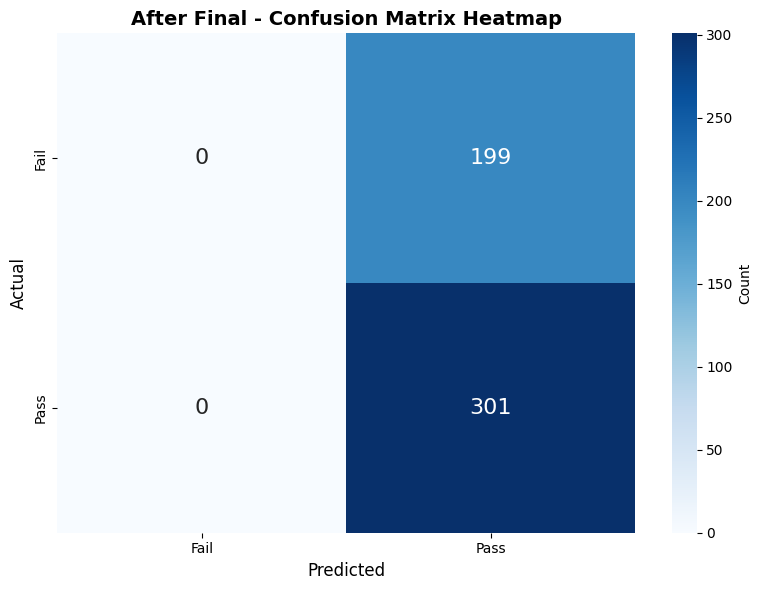

In [95]:
# Test on Test.
X_test_a = test_df[features_lst].to_numpy()
test_y_true = test_df['Grade'].to_numpy()
test_y_pred = ((X_test_a @ w_avg + b_avg) > 0).astype(int)
n_correct_test = (test_y_true==test_y_pred).sum(axis=0)

print(f"The number of correct preds was {n_correct_test} for acc of {(n_correct_test/test_y_true.shape[0])*100}%")
print(f"The number of pos preds was {(test_y_pred==1).sum(axis=0)} and neg num was {(test_y_pred==0).sum(axis=0)}")

# Additional detailed metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(test_y_true, test_y_pred)
precision = precision_score(test_y_true, test_y_pred, zero_division=0)
recall = recall_score(test_y_true, test_y_pred, zero_division=0)
f1 = f1_score(test_y_true, test_y_pred, zero_division=0)
cm = confusion_matrix(test_y_true, test_y_pred)

print(f"\n{'='*70}")
print("Detailed Evaluation Metrics:")
print(f"{'='*70}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



print(f"\nPredictions breakdown:")
print(f"  Predicted Fail (0): {(test_y_pred==0).sum()}")
print(f"  Predicted Pass (1): {(test_y_pred==1).sum()}")
print(f"  Actual Fail (0): {(test_y_true==0).sum()}")
print(f"  Actual Pass (1): {(test_y_true==1).sum()}")

# Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'],
            annot_kws={'size': 16}, cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('After Final - Confusion Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()